In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from func_file_Model import *
from func_file_Localization import *

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Load model and sample data

In [3]:
model = Load_CNN_model("Model/CNN_model.h5")
sample = np.load("Data/Sample_3.npy")

sample_restricted = sample[15:]

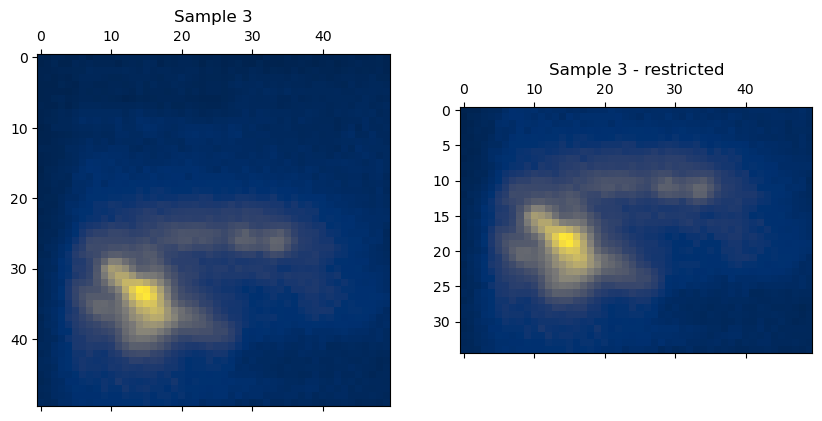

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(sample, cmap="cividis", fignum=False)
plt.title("Sample 3")

plt.subplot(122)
plt.matshow(sample_restricted, cmap="cividis", fignum=False)
plt.title("Sample 3 - restricted")

plt.show()

### CNN reconstruction

In [5]:
reconstructed = CNN_predict(model, sample)
reconstructed_restricted = reconstructed[61:]

1/1 [==============================] - 2s 2s/step


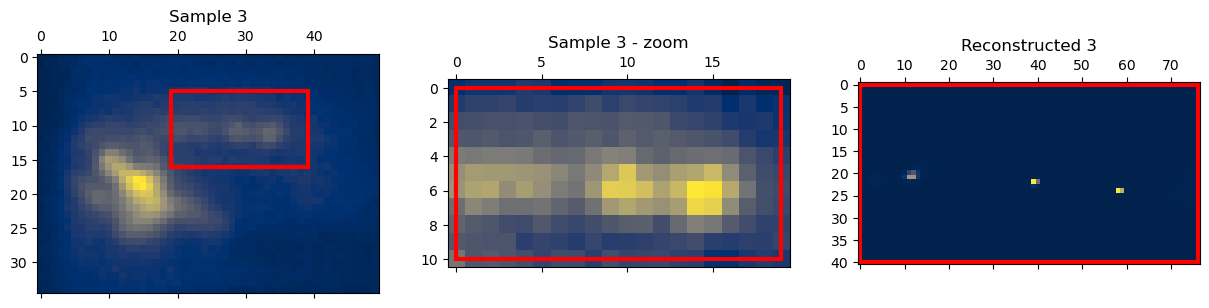

In [6]:
x0, y0 = (5, 19)
x, y = (10, 19)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.matshow(sample_restricted, cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Rectangle([y0,x0], y+1, x+1, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 3")

plt.subplot(132)
plt.matshow(sample_restricted[x0:(x0+x)+1, y0:(y0+y)+1], cmap="cividis", fignum=False)
plt.gca().add_patch(mpl.patches.Rectangle([0,0], y, x, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Sample 3 - zoom")

plt.subplot(133)
plt.matshow(reconstructed_restricted[int(4*x0+1.5):int(4*(x0+x)+1.5)+1, int(4*y0+1.5):int(4*(y0+y)+1.5)+1], cmap="cividis", fignum=False, 
            vmax=0.25*np.max(reconstructed_restricted[int(4*x0+1.5):int(4*(x0+x)+1.5)+1, int(4*y0+1.5):int(4*(y0+y)+1.5)+1]))
plt.gca().add_patch(mpl.patches.Rectangle([0,0], 4*y, 4*x, linewidth=3, edgecolor='red', facecolor='none'))
plt.title("Reconstructed 3")

plt.show()

### Fit a double-Gaussian function to estimate width

#### Calculate centers of mass

In [7]:
#Supporting variables
zoomed_reconstruction = reconstructed_restricted[int(4*x0+1.5):int(4*(x0+x)+1.5)+1, int(4*y0+1.5):int(4*(y0+y)+1.5)+1]

positions_of_max = [
    np.unravel_index(np.argmax(zoomed_reconstruction[:,0:20]), [41,20]) + np.array([0,0]), 
    np.unravel_index(np.argmax(zoomed_reconstruction[:,30:50]), [41,20]) + np.array([0,30]),
    np.unravel_index(np.argmax(zoomed_reconstruction[:,50:70]), [41,20]) + np.array([0,50])
]
positions_of_max

[array([21, 11]), array([22, 39]), array([24, 58])]

In [8]:
#Calculate the centers of mass
center_of_mass_array = np.zeros([3,2])

for i in range(center_of_mass_array.shape[0]):
    a, b = positions_of_max[i]
    center_of_mass_array[i] = scipy.ndimage.center_of_mass(zoomed_reconstruction[a-4:a+5, b-4:b+5])
    center_of_mass_array[i] += np.array([a-4, b-4])

center_of_mass_array

array([[20.69268092, 11.60924649],
       [22.02633479, 39.13271155],
       [23.99181428, 58.16084737]])

#### Fit double-Gaussian function

In [9]:
dg_cut_0 = (3, 26)
dg_cut = (19, 42)

dg_area = np.copy(sample_restricted[dg_cut_0[0]:dg_cut[0], dg_cut_0[1]:dg_cut[1]])
dg_area -= dg_area.min()

dg_params, dg_stds = Fit_Double_Arbitrary_Gauss(dg_area, 3)
print("Double Arbitrary Gauss parameters", 
      "\n-> Dot 1:", np.round(dg_params[:6],4), 
      "\n-> Dot 2:", np.round(dg_params[6:12],4), 
      "\n-> Offset:", np.round(dg_params[12],4))

Double Arbitrary Gauss parameters 
-> Dot 1: [  7.4966   2.4153 395.5651   2.7146   3.0001   0.5643] 
-> Dot 2: [  8.0412   7.6717 477.5322   2.2294   2.5969   0.    ] 
-> Offset: 96.0981


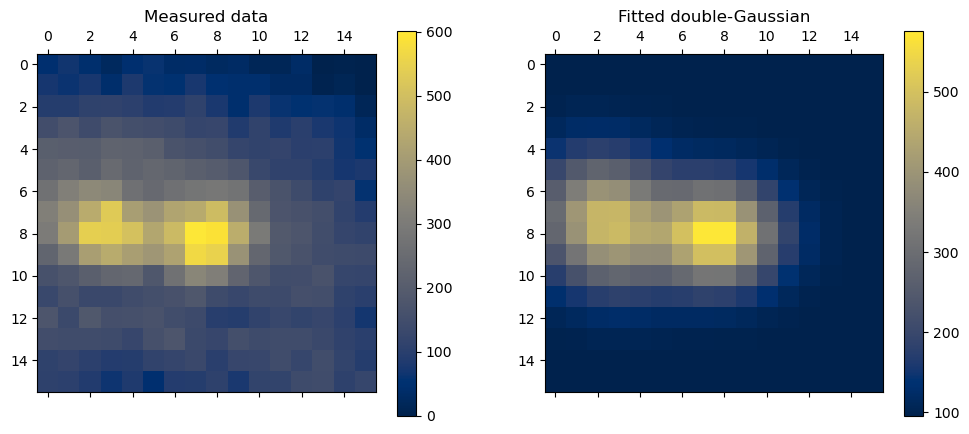

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.matshow(dg_area, cmap="cividis", fignum=False)
plt.title("Measured data")
plt.colorbar()

plt.subplot(122)
plt.matshow(Double_Arbitrary_Gauss_function(np.indices((dg_area.shape[0],dg_area.shape[1])), *dg_params), 
            cmap="cividis", fignum=False)
plt.title("Fitted double-Gaussian")
plt.colorbar()

plt.show()

In [11]:
print("The estimated effective width of the first dot:", 
      "\n-> Using double-Gaussian:", np.sqrt(np.mean(np.array([dg_params[3], dg_params[4]])**2)).round(4), "\n")

print("The estimated effective width of the second dot:", 
      "\n-> Using double-Gaussian:", np.sqrt(np.mean(np.array([dg_params[9], dg_params[10]])**2)).round(4))

The estimated effective width of the first dot: 
-> Using double-Gaussian: 2.8609 

The estimated effective width of the second dot: 
-> Using double-Gaussian: 2.4201


### Estimate resolution variables

In [12]:
#Turn the sigma_x and sigma_y into single sigma_xy for each dot
sigmas = [np.sqrt(np.mean(np.array([dg_params[3], dg_params[4]])**2)), 
          np.sqrt(np.mean(np.array([dg_params[9], dg_params[10]])**2))]    #sqrt( (x**2 + y**2) / 2 )

#Average the four sigmas
sigmas_average = np.mean(sigmas)

#Get Rayleigh resolution limit; defined as first dark ring in the Airy disc
rayleigh_resolution_limit_in_50px = Gaussian_sigma_to_Airy_min(sigmas_average)
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_50px,4), "px of the 50x50 grid.")

#Rescale to um
px_to_camera_um_in_50px = 20
rayleigh_resolution_limit_in_camera_um = rayleigh_resolution_limit_in_50px * px_to_camera_um_in_50px
print("Estimated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_camera_um,4), "um in the camera plane.")

Estimated Rayleigh limit is app. 5.2116 px of the 50x50 grid.
Estimated Rayleigh limit is app. 104.2318 um in the camera plane.


In [13]:
#Calculate the Rayleigh limit using imaging setup parameters
wavelength = 740 #720-760 nm
NA = 0.7

rayleigh_resolution_limit_in_sample_um = (0.61 * wavelength / NA) / 1000
print("Calculated Rayleigh limit is app.", np.round(rayleigh_resolution_limit_in_sample_um,4), "um in the sample plane.")

Calculated Rayleigh limit is app. 0.6449 um in the sample plane.


In [14]:
#Estimate the magnification of the imaging setup
magnification = rayleigh_resolution_limit_in_camera_um / rayleigh_resolution_limit_in_sample_um
print("Estimated magnification of the imaging setup is app.", np.round(magnification, 2))

Estimated magnification of the imaging setup is app. 161.64


In [15]:
#Calculate the distance of each reconstructed dot
dot_distance_1_in_200px = np.linalg.norm(center_of_mass_array[0] - center_of_mass_array[1])
dot_distance_2_in_200px = np.linalg.norm(center_of_mass_array[1] - center_of_mass_array[2])
print("First dot distance is app.", np.round(dot_distance_1_in_200px,4), "px of the 200x200 grid.")
print("Second dot distance is app.", np.round(dot_distance_2_in_200px,4), "px of the 200x200 grid.\n")

dot_distance_1_in_50px = dot_distance_1_in_200px / 4
dot_distance_2_in_50px = dot_distance_2_in_200px / 4
print("First dot distance is app.", np.round(dot_distance_1_in_50px,4), "px of the 50x50 grid.")
print("Second dot distance is app.", np.round(dot_distance_2_in_50px,4), "px of the 50x50 grid.\n")

dot_distance_1_in_camera_um = dot_distance_1_in_50px * px_to_camera_um_in_50px
dot_distance_2_in_camera_um = dot_distance_2_in_50px * px_to_camera_um_in_50px
print("First dot distance is app.", np.round(dot_distance_1_in_camera_um,4), "um in the camera plane.")
print("Second dot distance is app.", np.round(dot_distance_2_in_camera_um,4), "um in the camera plane.\n")

dot_distance_1_in_sample_um = dot_distance_1_in_camera_um / magnification
dot_distance_2_in_sample_um = dot_distance_2_in_camera_um / magnification
print("First dot distance is app.", np.round(dot_distance_1_in_sample_um,4), "um in the sample plane.")
print("Second dot distance is app.", np.round(dot_distance_2_in_sample_um,4), "um in the sample plane.")

First dot distance is app. 27.5558 px of the 200x200 grid.
Second dot distance is app. 19.1294 px of the 200x200 grid.

First dot distance is app. 6.8889 px of the 50x50 grid.
Second dot distance is app. 4.7823 px of the 50x50 grid.

First dot distance is app. 137.7788 um in the camera plane.
Second dot distance is app. 95.6469 um in the camera plane.

First dot distance is app. 0.8524 um in the sample plane.
Second dot distance is app. 0.5917 um in the sample plane.
